In [12]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Library/Mobile Documents/com~apple~CloudDocs/Master/Applied Mathematical Optimization/Project/Git/AMO_Project`


┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4-8a62-49f30b1f605e/agent-cache/default-macmini-x64-6.0/build/default-macmini-x64-6-0/julialang/julia-release-1-dot-8/usr/share/julia/stdlib/v1.8/Pkg/src/API.jl:1532


Status `~/Library/Mobile Documents/com~apple~CloudDocs/Master/Applied Mathematical Optimization/Project/Git/AMO_Project/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [336ed68f] CSV v0.10.9
  [aaaa29a8] Clustering v0.14.3
  [a9b2a840] Complementarity v0.9.0
⌃ [a93c6f00] DataFrames v1.4.4
  [864edb3b] DataStructures v0.18.13
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.80
  [5789e2e9] FileIO v1.16.0
⌃ [87dc4568] HiGHS v1.4.1
  [7073ff75] IJulia v1.24.0
  [916415d5] Images v0.25.2
  [b6b21f68] Ipopt v1.1.0
  [c8e1da08] IterTools v1.4.0
⌃ [4076af6c] JuMP v1.6.0
⌃ [b8f27783] MathOptInterface v1.11.4
  [8314cec4] PGFPlotsX v1.5.3
  [f0f68f2c] PlotlyJS v0.18.10
⌃ [91a5bcdd] Plots v1.38.2
⌃ [67491407] Polyhedra v0.7.5
  [f3b207a7] StatsPlots v0.15.4
  [fdbf4ff8] XLSX v0.8.4
  [9a3f8284] Random
  [10745b16] Statistics
Info Packages marked with ⌃ have new versions available and may be upgradable.
Warning The project dependencies or compat requirements have changed since t

In [13]:
# die pakete die wir für dieses Notebook brauchen
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV
using HiGHS
using StatsPlots

## Stochastic Market Clearing Formulation

For the stochastic market clearing a two-stage stochastic programming approach is used. This means, that the day-ahead market and the balancing market are cleared simultaneously, to cooptimize energy and reserve capacity. This simultaneous approach captures the coupling existing between these two commodities and reduces the so-called expected system operation cost (total cost), compared to a sequential approach. 

In [14]:
# read in the generated scenarios (see ScenarioGen+Red.ipynb for details)
scenarios = []
for i in 1:43
    push!(scenarios,CSV.read("./data/scenarios_new/scenarios_hour$i.csv",DataFrame))
end
scenarios[1][2,:]
# read in the probabilities for the scenarios
probabilities = CSV.read("./data/scenarios_new/probabilities.csv", DataFrame)

println(scenarios[1])
println(probabilities)

4×5 DataFrame
 Row │ Column1   Column2   Column3   Column4   Column5  
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 113.47    145.96    144.499   146.994   150.768
   2 │ 136.973   137.162   139.765   104.068   146.868
   3 │  54.8948   39.8038   54.1716   54.882    58.7665
   4 │  42.9557   43.8939   33.6926   42.6606   44.8779
43×5 DataFrame
 Row │ Scen1    Scen2    Scen3    Scen4    Scen5   
     │ Float64  Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────
   1 │  0.1796   0.1976   0.1914   0.1706   0.2608
   2 │  0.185    0.1776   0.1948   0.2672   0.1754
   3 │  0.1886   0.1782   0.2864   0.1636   0.1832
   4 │  0.1686   0.18     0.1666   0.2984   0.1864
   5 │  0.1658   0.2888   0.1796   0.1938   0.172
   6 │  0.1822   0.314    0.1706   0.1578   0.1754
   7 │  0.1772   0.167    0.3022   0.1758   0.1778
   8 │  0.3038   0.1718   0.1678   0.1718   0.1848
   9 │  0.1894 

In [15]:
#Transform scenario data (to able get value by windata[hour][zone][scenario])
wind_data =  [[[scenarios[h][w,s] for s in 1:5] for w in 1:4] for h in 1:43]
prob_data =  [[probabilities[h,s] for s in 1:5] for h in 1:43]
println(wind_data[12][2][1]) # value for scenario 1 of zone 2 at hour 12
println(prob_data[12][1]) # probability for scenario 1 at hour 12

172.91544928425168
0.176


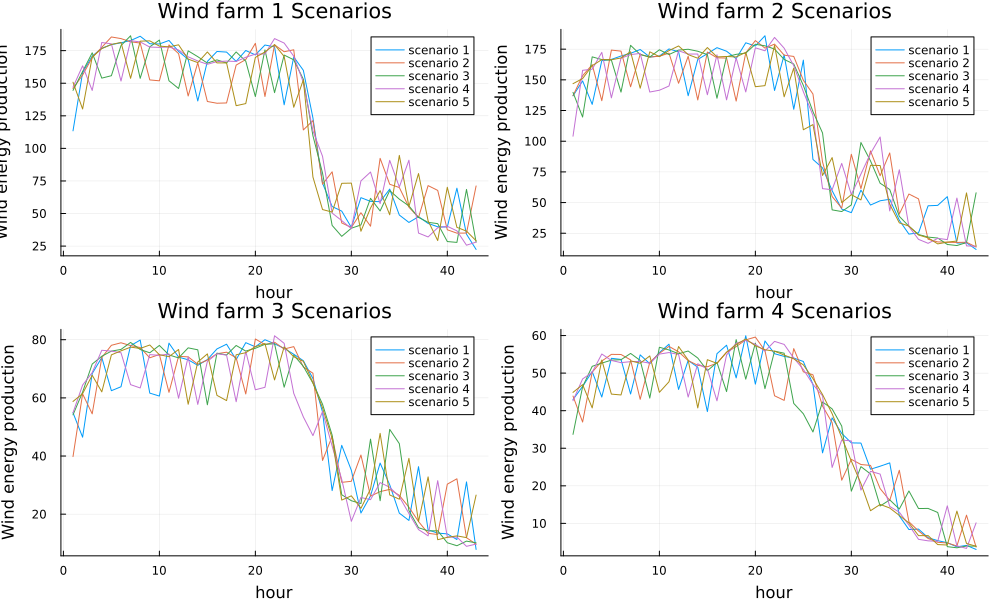

In [16]:
# look at scenario values
function get_plot(i,df)
    a = plot(collect(1:43),[df[k][i,1] for k in 1:43] ,label = "scenario 1", xlabel = "hour", ylabel = "Wind energy production", title = "Wind farm " * string(i) * " Scenarios")
    plot!(collect(1:43),[df[k][i,2] for k in 1:43] ,label = "scenario 2", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,3] for k in 1:43] ,label = "scenario 3", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,4] for k in 1:43] ,label = "scenario 4", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,5] for k in 1:43] ,label = "scenario 5", xlabel = "hour", ylabel = "Wind energy production")

    return a
end
plot(get_plot(1,scenarios),get_plot(2,scenarios),get_plot(3,scenarios),get_plot(4,scenarios),layout = (2,2),size = (1000,600))

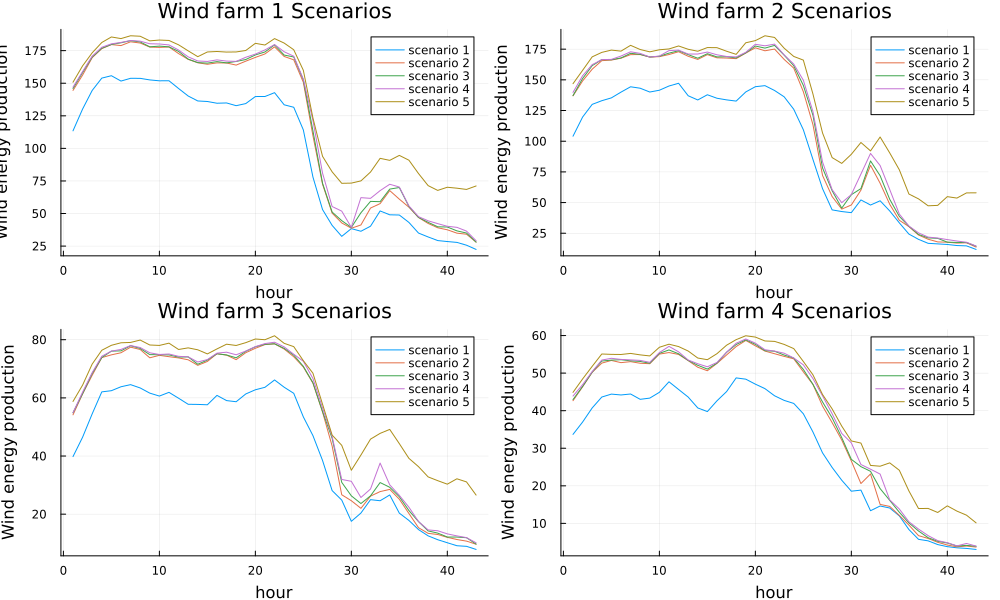

In [17]:
# Sort scenarios for better visibility (This is possible since scenarios across different hours are completly independent, meaning the scenario index across hours is meaningless)
sorted_scenarios = deepcopy(scenarios)
for k in 1:43, i in 1:4
    sorted_scenarios[k][i,:] = sort!(Array(sorted_scenarios[k][i,:]))
end
plot(get_plot(1,sorted_scenarios),get_plot(2,sorted_scenarios),get_plot(3,sorted_scenarios),get_plot(4,sorted_scenarios),layout = (2,2),size = (1000,600))

In [18]:
wind_data[1][1][1]

113.47039204738206

In [36]:
function solveModel(t::Int,data)
    m = Model(HiGHS.Optimizer)
    @variable(m, 0 <= PG[k in data[:K]] <= data[:Pmax][k]) # Power output of Generators
    @variable(m, 0 <= PW[w in data[:W]] <= data[:Wmax][w]) # schdeuled Power output of Windfarm --> max is capacity
    @variable(m, 0 <= Ru[k in data[:K]] <= data[:Rmax][k]) # Upward schelduled Reserve for each Generator
    @variable(m, 0 <= Rd[k in data[:K]] <= data[:Rmax][k]) # Downward scheduled Reserve for each Generator
    @variable(m, 0 <= Wspill[s in data[:S]] <= sum(data[:wind][t][w][s] for w in data[:W])) # Wind spillage for each scenario(no cost)
    @variable(m, 0 <= Lshed[s in data[:S]] <= sum(data[:D])) # Load shedding for each scenario
    @variable(m, 0 <= ru[k in data[:K],s in data[:S]]) #upward balancing for each scenario
    @variable(m, 0 <= rd[k in data[:K],s in data[:S]]) #downward balancing for each scenario

    @constraint(m,λ, sum(PG) + sum(PW) - sum(data[:D]) == 0) # balancing energy in day-ahead
    @constraint(m,Puu[k in data[:K], s in data[:S]], ru[k,s] <= Ru[k]) #  upward reserve dispatched cant be larger than allocated upward reserve
    @constraint(m,Pdu[k in data[:K], s in data[:S]], rd[k,s] <= Rd[k]) # downward reserve dispatched cant be larger than allocated downward reserve
    for s in data[:S]
        @constraint(m, sum(ru[k,s] - rd[k,s] for k in data[:K]) + Lshed[s] + sum(data[:wind][t][w][s] for w in data[:W]) - sum(PW) - Wspill[s] == 0) # balancing energy in real-time scenarios
    end
    @constraint(m, uRmax[k in data[:K]], PG[k] + Ru[k] <= data[:Pmax][k]) # Upward reserve + Poweroutput <= Ma  x Capacity
    @constraint(m, dRmax[k in data[:K]], PG[k] - Rd[k] >= 0) # Poweroutput - Downward reserve >= 0
    
    @expression(m,Cexp,sum(data[:prob][t][s] * ((sum(data[:C][k] * (ru[k,s] - rd[k,s]) for k in data[:K]) + data[:vLOL]*Lshed[s])) for s in data[:S]))

    @objective(m,Min, sum(data[:C][k]*PG[k] + data[:Cu][k]*Ru[k] + data[:Cd][k]*Rd[k] for k in data[:K]) + Cexp) #Balancing costs for each scenario

    JuMP.optimize!(m)

    return Dict(:objective_value => objective_value(m),
    :generator_values => [value(PG[k]) for k in data[:K]],
    :wind_values => [value(PW[k]) for k in data[:W]],
    :shadow_prices => -1 * shadow_price(λ),
    :expected_cost => value(Cexp),
    :Wspills => [value(Wspill[k]) for k in data[:W]],
    :Ureserve => [value(Ru[k]) for k in data[:K]],
    :Dreserve => [value(Rd[k]) for k in data[:K]],
    :Lshed => [value(Lshed[k]) for k in data[:S]],
    :ru => [[value(ru[k,s]) for k in 1:12] for s in 1:5])
end

solveModel (generic function with 1 method)

In [37]:
data = Dict(
    :S => 1:5, # Scenarios index
    :W => 1:4, # Wind farm index
    :K => 1:12, # Generator index
    :L => 1:17, # Load index
    :C => [99,137,151,175,183,59.5,42,64,60.2,79,58,108], # Generator Energy cost
    :Cu => [1.68,1.68,3.30,4.07,1.89,5.48,5.48,4.98,5.53,8.00,3.45,5.11], # Generator upward reserve cost
    :Cd => [2.32,2.32,4.67,3.93,3.11,3.52,3.52,5.02,4.97,6.00,2.52,2.89], # Generator downward reserve cost
    :Rmax => [48,48,84,216,42,36,36,60,60,48,72,48], # Generator reserve capacity (both up and down)
    :Pmax => [106.4,106.4,245,413.7,42,108.5,108.5,280,280,210,217,245], # Generator max Capacity
    :Wmax =>[500,500,300,300], # Wind farm max capacity
    :D =>[84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100], # Demand energy
    :vLOL => 500.0, # value of lost load
    :wind => wind_data,
    :prob => prob_data,
    :R => 0.1 * sum([84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100]) # Reserve volume
)

resultsDf = DataFrame(objective = Float64[], sum_generators = Float64[],
    sum_wind = Float64[],expected_wind = Float64[], price = Float64[],Cexp = Float64[], Lshed = Float64[],Wspill = Float64[],Ureserve = Float64[],Dreserve=Float64[])

generator_data = []
UReserve_data = []
DReserve_data =[]
Wind_data = []
expected_costs = []
Lshed = []
Wspills = []
ru = []

for i in 1:43
    results = solveModel(i,data)
    println(typeof(results))
    push!(generator_data,results[:generator_values])
    push!(UReserve_data,results[:Ureserve])
    push!(DReserve_data,results[:Dreserve])
    push!(Wind_data,results[:wind_values])
    push!(Lshed,results[:Lshed])
    push!(Wspills,results[:Wspills])
    push!(ru,results[:ru])
    push!(resultsDf,[results[:objective_value],sum(results[:generator_values]),sum(results[:wind_values]),sum([prob_data[i][k]* sum(wind_data[i][w][k] for w in 1:4) for k in 1:5]),
            results[:shadow_prices],results[:expected_cost],sum(results[:Lshed]),sum(results[:Wspills]),sum(results[:Ureserve]),sum(results[:Dreserve])])
end

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.2156967431e+03 Ph1: 65(120); Du: 60(1215.7) 0s
        118     1.5310657671e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 118
Objective value     :  1.5310657671e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
U

{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.2156966909e+03 Ph1: 65(120); Du: 60(1215.7) 0s
        118     1.4257205299e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 118
Objective value     :  1.4257205299e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the 

{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.2156967168e+03 Ph1: 65(120); Du: 60(1215.7) 0s
        118     1.4068009319e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 118
Objective value     :  1.4068009319e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the 

{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.2156966630e+03 Ph1: 65(120); Du: 60(1215.7) 0s
        118     1.3746878134e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 118
Objective value     :  1.3746878134e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the 

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.2156968993e+03 Ph1: 65(120); Du: 60(1215.7) 0s
        130     1.8256345825e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 130
Objective value     :  1.8256345825e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
U

## Results

In [38]:
Wind_data

43-element Vector{Any}:
 [0.0, 0.0, 101.27994075489744, 300.0]
 [0.0, 0.0, 133.96274946734752, 300.0]
 [0.0, 0.0, 165.52432895763496, 300.0]
 [0.0, 0.0, 185.09821452294477, 300.0]
 [0.0, 0.0, 192.8242341877591, 300.0]
 [0.0, 0.0, 191.57472933944223, 300.0]
 [0.0, 0.0, 198.85843306796505, 300.0]
 [0.0, 0.0, 195.52001995742575, 300.0]
 [0.0, 0.0, 188.10883003693175, 300.0]
 [0.0, 0.0, 192.56301190868527, 300.0]
 ⋮
 [0.0, 0.0, 0.0, 157.87474398587472]
 [0.0, 0.0, 0.0, 126.39640568474192]
 [0.0, 0.0, 0.0, 100.30411024688038]
 [0.0, 0.0, 0.0, 66.71847133884941]
 [0.0, 0.0, 0.0, 61.16013623583974]
 [0.0, 0.0, 0.0, 58.3422666194682]
 [0.0, 0.0, 0.0, 55.478808743266185]
 [0.0, 0.0, 0.0, 52.67414584161557]
 [0.0, 0.0, 0.0, 45.189059871641206]

In [39]:
println(resultsDf)

43×10 DataFrame
 Row │ objective       sum_generators  sum_wind  expected_wind  price    Cexp       Lshed    Wspill   Ureserve  Dreserve 
     │ Float64         Float64         Float64   Float64        Float64  Float64    Float64  Float64  Float64   Float64  
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │      1.53107e5         1805.72  401.28         370.388     151.0   4664.64       0.0      0.0  52.9859     0.0
   2 │ 147681.0               1773.04  433.963        406.188     151.0   4194.03       0.0      0.0  46.9821     0.0
   3 │      1.42572e5         1741.48  465.524        439.999     151.0   3854.31       0.0      0.0  45.9307     0.0
   4 │      1.3939e5          1721.9   485.098        461.106     151.0   3622.77       0.0      0.0  47.436      0.0
   5 │      1.38591e5         1714.18  492.824        466.405     151.0   3989.33       0.0      0.0  47.832      0.0
   6 │      1.38154e5       

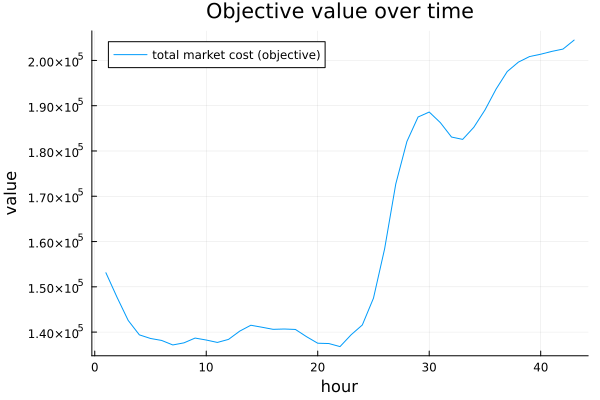

In [40]:
plot(collect(1:43),resultsDf.objective ,label = "total market cost (objective)", xlabel = "hour", ylabel = "value",title="Objective value over time")

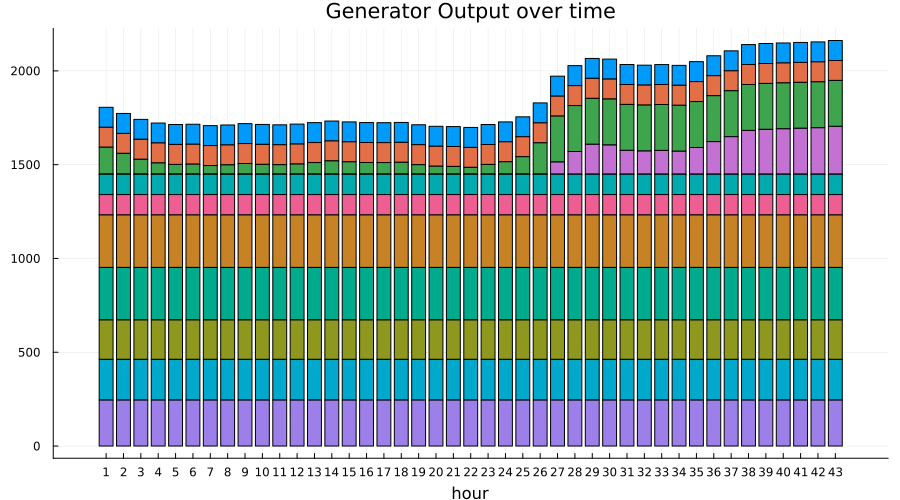

In [41]:
gen_data_pretty = [[generator_data[i][k] for i in 1:43] for k in 1:12]
groupedbar(hcat(gen_data_pretty...) , bar_position = :stack ,xticks = (1:43,1:43),size=(900,500),xlabel = "hour",
    label = permutedims(hcat(["G" * string(i) for i in 1:12])),title = "Generator Output over time", legend =false )

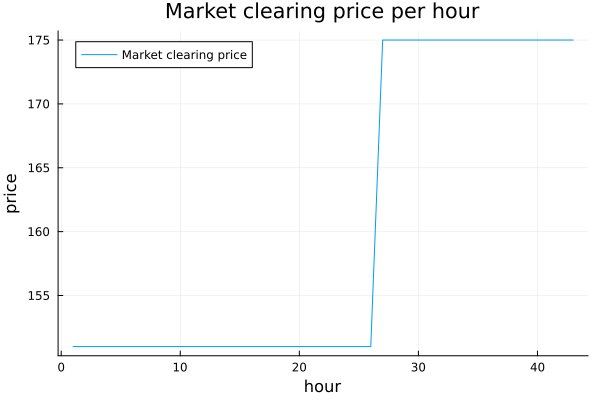

In [42]:
plot(collect(1:43),resultsDf.price ,label = "Market clearing price", xlabel = "hour", ylabel = "price",title="Market clearing price per hour")#ylims=(10,21))

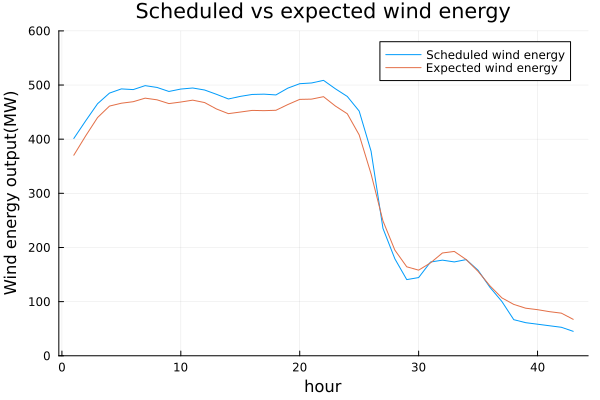

In [43]:
plot(collect(1:43),resultsDf.sum_wind ,label = "Scheduled wind energy", xlabel = "hour", ylabel = "Wind energy output(MW)",title="Scheduled vs expected wind energy",ylims=(0,600))
plot!(collect(1:43),resultsDf.expected_wind ,label = "Expected wind energy")

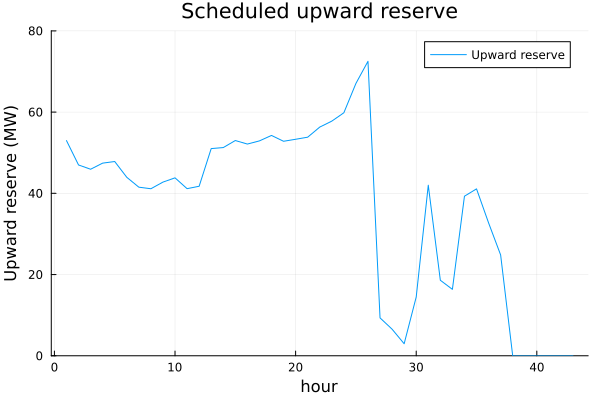

In [44]:
plot(collect(1:43),resultsDf.Ureserve ,label = "Upward reserve", xlabel = "hour", ylabel = "Upward reserve (MW)",title="Scheduled upward reserve",ylims=(0,80))

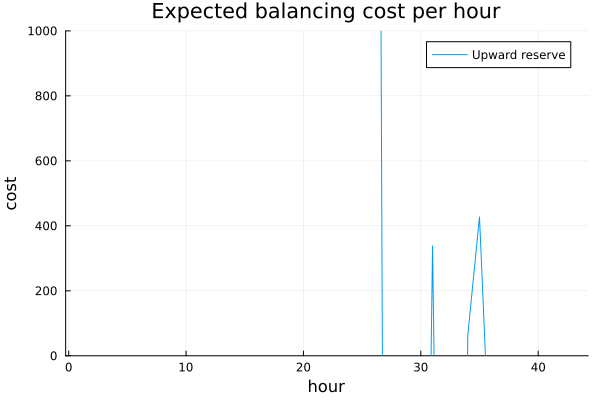

In [45]:
plot(collect(1:43),resultsDf.Cexp ,label = "Upward reserve", xlabel = "hour", ylabel = "cost",title="Expected balancing cost per hour",ylims=(0,1000))